# Tutorial 8: Workflow Example

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/donishadsmith/neurocaps/blob/stable/docs/examples/tutorial-8.ipynb)

This tutorial demonstrates an example workflow from timeseries extraction to CAPs visualization. Two subjects from a real, publicly available dataset are used so it may take a few minutes to download the files.

In [4]:
# Allow plotly to render correctly on static websites
import plotly.io as pio

pio.renderers.default = "svg"

# Download packages
try:
    import neurocaps
except:
    !pip install neurocaps[windows,demo]

# Set headless display for google colab
import os, sys

if "google.colab" in sys.modules:
    os.environ["DISPLAY"] = ":0.0"
    !apt-get install -y xvfb
    !Xvfb :0 -screen 0 1024x768x24 &> /dev/null &
    !Xvfb :0 -screen 0 1024x768x24 &> /dev/null &

In [5]:
import os

demo_dir = "neurocaps_demo"
os.makedirs(demo_dir, exist_ok=True)

The code below fetches two subjects from an [OpenNeuro dataset](https://openneuro.org/datasets/ds003521/versions/2.2.0) ([from Chang et al. (2021)](https://doi.org/10.1126/sciadv.abf7129))
preprocessed with [fMRIPrep](https://fmriprep.org/en/stable/). Downloading data from OpenNeuro requires
``pip install openneuro-py ipywidgets`` or ``pip install neurocaps[demo]``.

In [6]:
# [Dataset] https://openneuro.org/datasets/ds003521/versions/2.2.0
from openneuro import download

# Include data from two subjects
include = [
    "dataset_description.json",
    "sub-sid000216/func/*events.tsv",
    "derivatives/fmriprep/sub-sid000216/func/*confounds_timeseries.tsv",
    "derivatives/fmriprep/sub-sid000216/func/*preproc_bold.nii.gz",
    "sub-sid000710/func/*events.tsv",
    "derivatives/fmriprep/sub-sid000710/func/*confounds_timeseries.tsv",
    "derivatives/fmriprep/sub-sid000710/func/*preproc_bold.nii.gz",
]

download(
    dataset="ds003521",
    include=include,
    target_dir=demo_dir,
    verify_hash=False,
    max_retries=10,
    max_concurrent_downloads=7,
)


👋 Hello! This is openneuro-py 2024.2.0. Great to see you! 🤗

   👉 Please report problems 🤯 and bugs 🪲 at
      https://github.com/hoechenberger/openneuro-py/issues

🌍 Preparing to download ds003521 …


📁 Traversing directories for ds003521 : 0 entities [00:00, ? entities/s]

📥 Retrieving up to 10 files (7 concurrent downloads). 
✅ Finished downloading ds003521.
 
🧠 Please enjoy your brains.
 


The first level of the pipeline directory must also have a dataset_description.json file for querying purposes.


In [9]:
import glob, json, os

desc = {
    "Name": "fMRIPrep - fMRI PREProcessing workflow",
    "BIDSVersion": "1.0.0",
    "DatasetType": "derivative",
    "GeneratedBy": [
        {"Name": "fMRIPrep", "Version": "20.2.0", "CodeURL": "https://github.com/nipreps/fmriprep"}
    ],
}

with open(
    "neurocaps_demo/derivatives/fmriprep/dataset_description.json", "w", encoding="utf-8"
) as f:
    json.dump(desc, f)

# Ensure files have the same run id if the "run-" entity is used.
for sub in ["sub-sid000216", "sub-sid000710"]:
    target_file = glob.glob(os.path.join(demo_dir, sub, "func", "*events.tsv"))[0]
    os.rename(target_file, target_file.replace("run-01", "run-1"))

In [2]:
from neurocaps.extraction import TimeseriesExtractor
from neurocaps.utils import fetch_preset_parcel_approach

# List of fMRIPrep-derived confounds for nuisance regression
confound_names = [
    "cosine*",
    "trans_x",
    "trans_x_derivative1",
    "trans_y",
    "trans_y_derivative1",
    "trans_z",
    "trans_z_derivative1",
    "rot_x",
    "rot_x_derivative1",
    "rot_y",
    "rot_y_derivative1",
    "rot_z",
    "rot_z_derivative1",
    "a_comp_cor_00",
    "a_comp_cor_01",
    "a_comp_cor_02",
    "a_comp_cor_03",
    "a_comp_cor_04",
    "global_signal",
    "global_signal_derivative1",
]

# Initialize extractor with signal cleaning parameters
extractor = TimeseriesExtractor(
    space="MNI152NLin2009cAsym",
    parcel_approach=fetch_preset_parcel_approach("4S", n_nodes=456),
    standardize=True,
    confound_names=confound_names,
    fd_threshold={
        "threshold": 0.50,
        "outlier_percentage": 0.30,
    },
)

# Perform the timeseries extraction; only one session
# can be extracted at a time. Internally, lru_cache is used for
# ``BidsLayout``. May need to clear cache if the cell was ran
# before the directory download completed
try:
    TimeseriesExtractor._call_layout.cache_clear()
except:
    pass

# Extract BOLD data from preprocessed fMRIPrep data
# which should be located in the "derivatives" folder
# within the BIDS root directory
# The extracted timeseries data is automatically stored
# Session 2 is the only session available, so `session`
# does not need to be specified
extractor.get_bold(
    bids_dir=demo_dir,
    task="movie",
    condition="Movie",
    condition_tr_shift=2,
    tr=2,
    verbose=False,
).timeseries_to_pickle(demo_dir, "timeseries.pkl")

2025-07-21 14:59:11,589 neurocaps.extraction._internals.confounds [INFO] Confound regressors to be used if available: cosine*, trans_x, trans_x_derivative1, trans_y, trans_y_derivative1, trans_z, trans_z_derivative1, rot_x, rot_x_derivative1, rot_y, rot_y_derivative1, rot_z, rot_z_derivative1, a_comp_cor_00, a_comp_cor_01, a_comp_cor_02, a_comp_cor_03, a_comp_cor_04, global_signal, global_signal_derivative1.
2025-07-21 14:59:13,001 neurocaps.extraction.timeseries_extractor [INFO] BIDS Layout: ...s\docs\examples\neurocaps_demo | Subjects: 2 | Sessions: 0 | Runs: 2


In [3]:
# Retrieve the dataframe containing QC information for each subject
# to use for downstream statistical analyses
qc_df = extractor.report_qc()
qc_df

,Subject_ID,Run,Mean_FD,Std_FD,Frames_Scrubbed,Frames_Interpolated,Mean_High_Motion_Length,Std_High_Motion_Length,N_Dummy_Scans
0,sid000216,run-1,0.082952,0.057038,2,0,1.00,0.000000,NaN
1,sid000710,run-1,0.083742,0.069571,5,0,1.25,0.433013,NaN


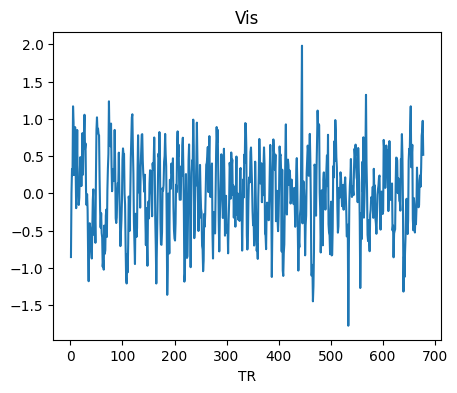

In [4]:
# Visualize BOLD Data
from neurocaps.utils import PlotDefaults

plot_kwargs = PlotDefaults.visualize_bold()
plot_kwargs["figsize"] = (5, 4)

extractor.visualize_bold(subj_id="sid000216", run=1, region="Vis", **plot_kwargs)

2025-07-21 14:59:39,912 neurocaps.analysis.cap._internals.cluster [INFO] No groups specified. Using default group 'All Subjects' containing all subject IDs from `subject_timeseries`. The `groups` dictionary will remain fixed unless the `CAP` class is re-initialized or `clear_groups()` is used.
2025-07-21 14:59:43,643 neurocaps.analysis.cap._internals.cluster [INFO] [GROUP: All Subjects | METHOD: variance_ratio] Optimal cluster size is 2.


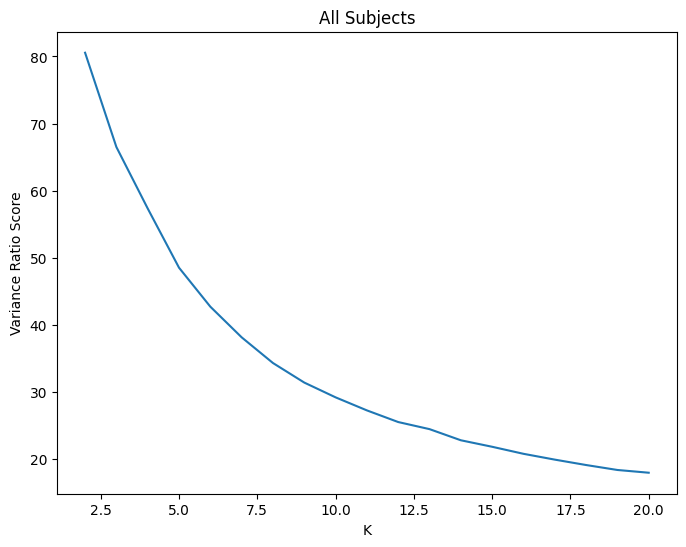

In [5]:
from neurocaps.analysis import CAP

# Initialize CAP class
cap_analysis = CAP(parcel_approach=extractor.parcel_approach)

# Identify the optimal number of CAPs (clusters)
# using the variance_ratio method to test 2-20
# The optimal number of CAPs is automatically stored
cap_analysis.get_caps(
    subject_timeseries=extractor.subject_timeseries,
    n_clusters=range(2, 21),
    standardize=True,
    cluster_selection_method="variance_ratio",
    max_iter=500,
    n_init=10,
    random_state=0,
    show_figs=True,
)

In [6]:
# Calculate temporal fraction and transition probability of each CAP for all subjects
output = cap_analysis.calculate_metrics(
    extractor.subject_timeseries, metrics=["temporal_fraction", "transition_probability"]
)
output["temporal_fraction"]

,Subject_ID,Group,Run,CAP-1,CAP-2
0,sid000216,All Subjects,run-1,0.448378,0.551622
1,sid000710,All Subjects,run-1,0.422222,0.577778


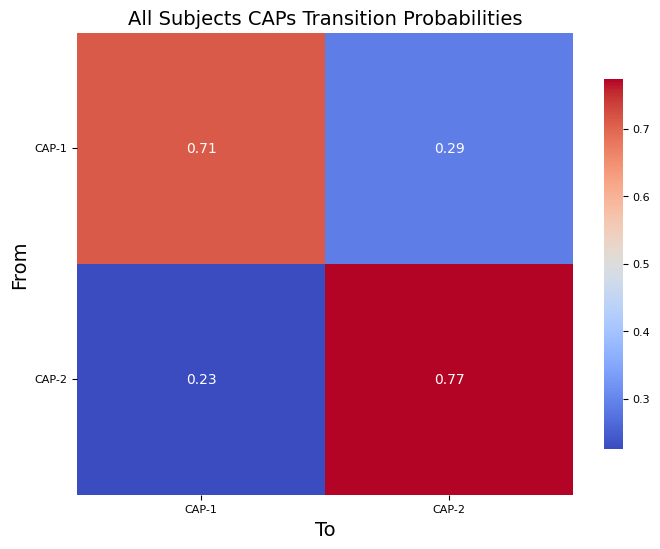

In [7]:
# Averaged transition probability matrix
from neurocaps.analysis import transition_matrix

df = transition_matrix(output["transition_probability"], return_df=True)

In [8]:
df["All Subjects"]

,CAP-1,CAP-2
From/To,,
CAP-1,0.710204,0.289796
CAP-2,0.226107,0.773893


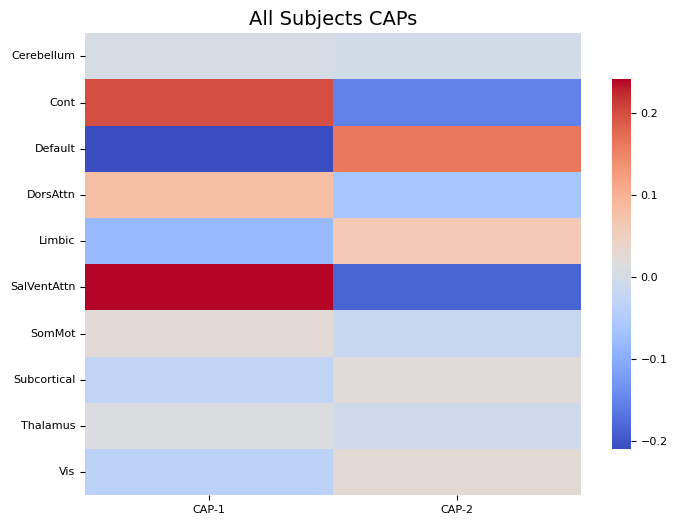

In [9]:
cap_analysis.caps2plot(plot_options="heatmap")

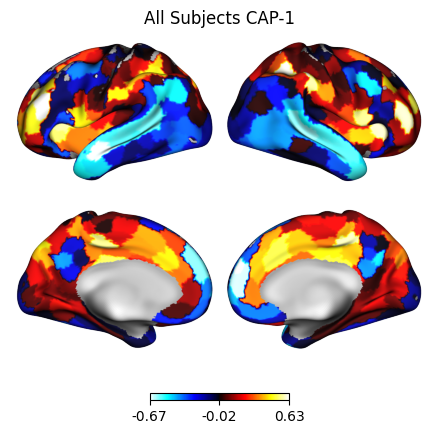

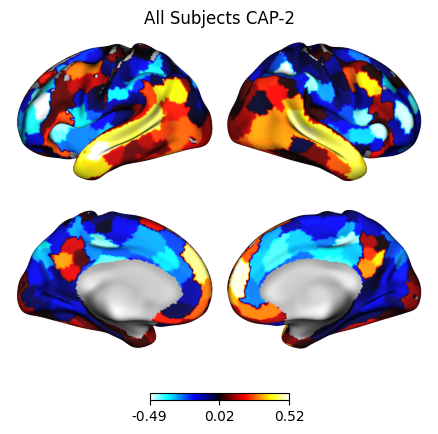

In [10]:
# Project CAPs onto surface plots
# and generate cosine similarity network alignment of CAPs

from neurocaps.utils import PlotDefaults

radialaxis = {
    "showline": True,
    "linewidth": 2,
    "linecolor": "rgba(0, 0, 0, 0.25)",
    "gridcolor": "rgba(0, 0, 0, 0.25)",
    "ticks": "outside",
    "tickfont": {"size": 14, "color": "black"},
    "range": [0, 0.9],
    "tickvals": [0.1, "", 0.3, "", 0.5, "", 0.7, "", 0.9],
}

color_discrete_map = {
    "High Amplitude": "rgba(255, 165, 0, 0.75)",
    "Low Amplitude": "black",
}

plot_kwargs = PlotDefaults.caps2radar()
plot_kwargs.update(dict(radialaxis=radialaxis, color_discrete_map=color_discrete_map))

cap_analysis.caps2surf().caps2radar(**plot_kwargs)